In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR

from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

import seaborn as sns
import statsmodels.api as sm


In [5]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Load data

In [6]:
# load dataset

dataframe = sm.datasets.macrodata.load_pandas().data
display(dataframe.head())

dataframe['quarter'] = dataframe['quarter'].astype(int).astype(str)
dataframe['year'] = dataframe['year'].astype(int).astype(str)
dataframe['index'] = pd.to_datetime(dataframe['year'] + 'Q' + dataframe['quarter'])

dataframe.set_index('index', inplace=True)




,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.00,1.00,2710.35,1707.40,286.90,470.05,1886.90,28.98,139.70,2.82,5.80,177.15,0.00,0.00
1,1959.00,2.00,2778.80,1733.70,310.86,481.30,1919.70,29.15,141.70,3.08,5.10,177.83,2.34,0.74
2,1959.00,3.00,2775.49,1751.80,289.23,491.26,1916.40,29.35,140.50,3.82,5.30,178.66,2.74,1.09
3,1959.00,4.00,2785.20,1753.70,299.36,484.05,1931.30,29.37,140.00,4.33,5.60,179.39,0.27,4.06
4,1960.00,1.00,2847.70,1770.50,331.72,462.20,1955.50,29.54,139.60,3.50,5.20,180.01,2.31,1.19


In [7]:
# create a time series
st = pd.Series(dataframe['realgdp'], index=dataframe.index)


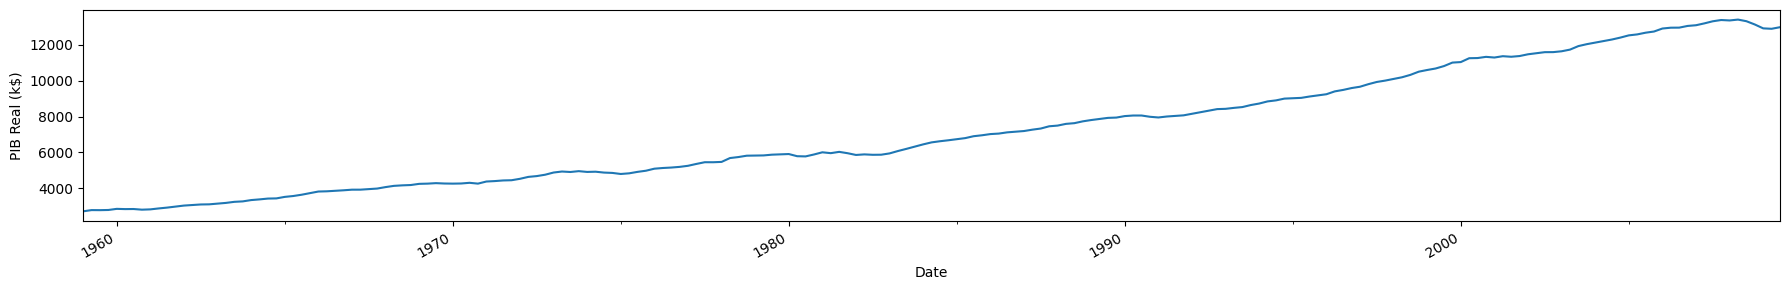

In [8]:

fig, ax = plt.subplots()
# basic plot
st.plot();
ax.set_xlabel('Date')
ax.set_ylabel('PIB Real (k$)')

fig.autofmt_xdate()
plt.tight_layout()

## identificación de patrones estacionales

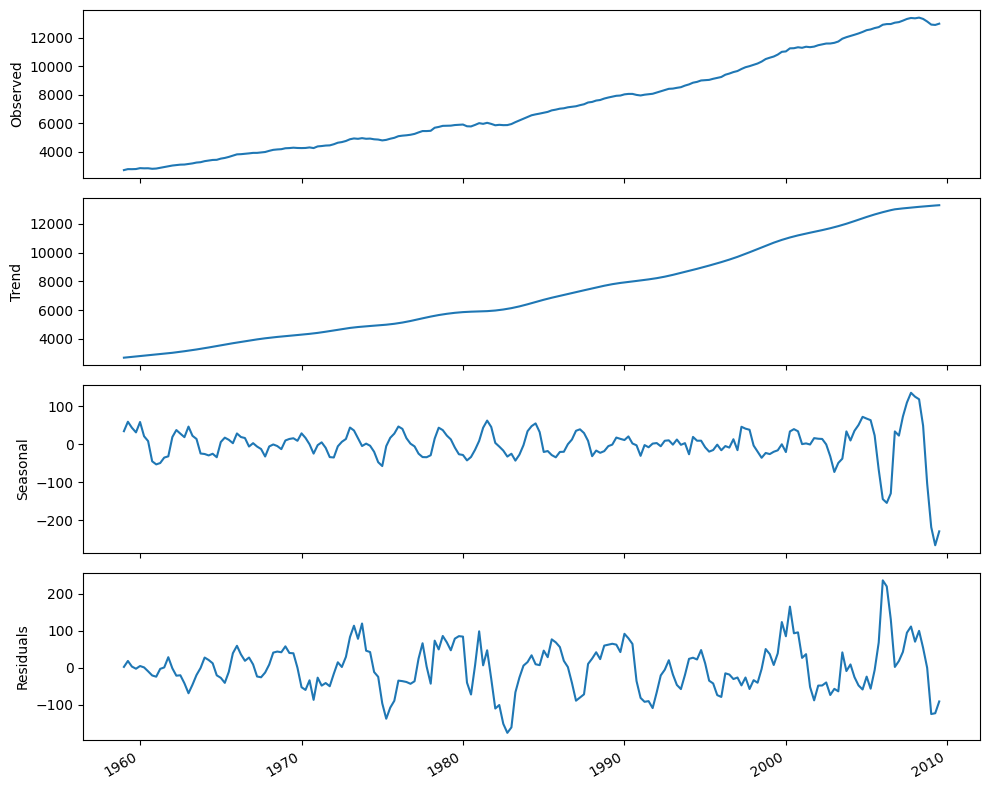

In [118]:
decomposition = STL(dataframe['realgdp'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')


fig.autofmt_xdate()
plt.tight_layout()

## Prueba de estacionariedad


In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, significance_level=0.05):

    """
    Realiza la prueba de Dickey-Fuller Aumentada en una serie de tiempo dada y evalúa su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser probados.
    significance_level (float): El nivel de significancia para la prueba (por defecto es 0.05).

    retorna:
    dict: Un diccionario que contiene el estadístico ADF, el valor p, los valores críticos y si la serie es estacionaria.

    """
    dftest = adfuller(timeseries)
    adf_statistic, p_value, used_lag, nobs, critical_values, icbest = dftest

    # Determinar si la serie es estacionaria basado en el valor p y el estadístico ADF
    is_stationary_p = p_value < significance_level
    is_stationary_adf = adf_statistic < critical_values['5%']  # Utiliza el valor crítico al 5%
    is_stationary = is_stationary_p and is_stationary_adf

    return {
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Values": critical_values,
        "Is Stationary (p-value)": is_stationary_p,
        "Is Stationary (ADF)": is_stationary_adf,
        "Is Stationary (Both)": is_stationary
    }



adf_test_results = test_stationarity(st)
adf_test_results



{'ADF Statistic': 1.7504627967647144,
 'p-value': 0.9982455372335032,
 'Critical Values': {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 'Is Stationary (p-value)': False,
 'Is Stationary (ADF)': False,
 'Is Stationary (Both)': False}

### Estacionalización serie de tiempo
mediante diferenciación recurrente y verifica su estacionariedad.

In [10]:
def make_stationary_recursive(time_series, significance_level=0.05, max_diff=10):
    """
    Estacionaliza una serie de tiempo mediante diferenciación recurrente y
    verifica su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser procesados.
    significance_level (float): El nivel de significancia para la prueba ADF (por defecto es 0.05).
    max_diff (int): El número máximo de diferenciaciones a aplicar.

    Retorna:
    tuple: Una tupla conteniendo el número de diferenciaciones aplicadas (d),
           la serie de tiempo diferenciada y los resultados de la prueba ADF.
    """
    d = 0  # Contador de diferenciaciones
    diff_series = time_series.copy()

    for i in range(max_diff):
        adf_test_results = test_stationarity(diff_series, significance_level)
        if adf_test_results['Is Stationary (Both)']:
            break
        else:
            diff_series = diff_series.diff().dropna()
            d += 1

    return d, diff_series, adf_test_results





In [11]:
d_count, diff_series, adf_results = make_stationary_recursive(st)
d_count, adf_results


(1,
 {'ADF Statistic': -6.305695561658106,
  'p-value': 3.327882187668224e-08,
  'Critical Values': {'1%': -3.463476079125,
   '5%': -2.876102355,
   '10%': -2.574532225},
  'Is Stationary (p-value)': True,
  'Is Stationary (ADF)': True,
  'Is Stationary (Both)': True})

##Train  test data

In [122]:
train_size = 192
train_st, test_st = st[:train_size], st[train_size:]
len(train_st), len(test_st)

(192, 11)

## Prueba de autocorrelación (ACF) y autocorrelacion parcial (PACF)

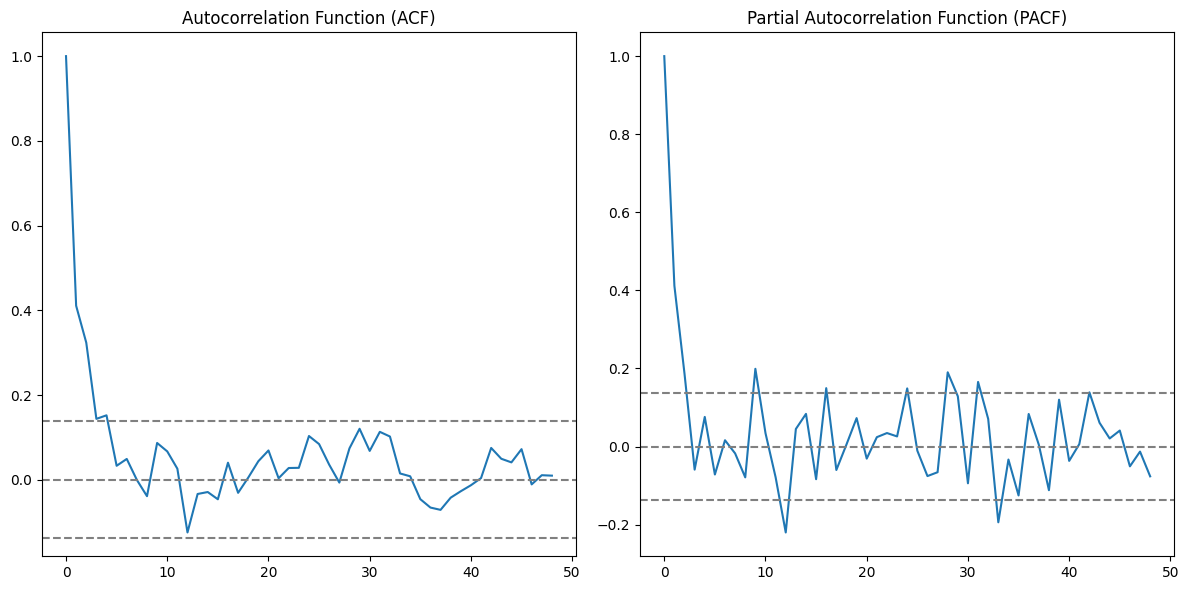

In [123]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

if d_count>0:
    train, test = diff_series[:train_size], diff_series[train_size:]


vnlag=min(100, len(train)//4)
lag_acf = acf(diff_series, nlags=vnlag)
lag_pacf = pacf(diff_series, nlags=vnlag, method='ols')

# Plotting ACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

plt.show()



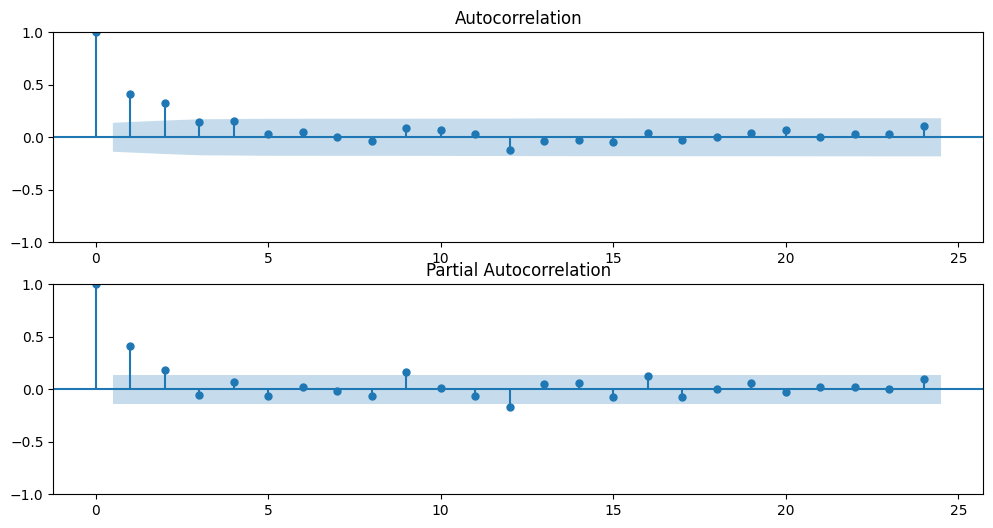

In [124]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplots(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff_series, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_series, ax=plt.gca())
plt.show()

## Modelo ARIMA

In [125]:
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit()
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df



### Mejor modelo ARIMA

In [126]:
ps =[1, 2,3]
qs=[1,2,3]
d = 1

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train_st, order_list, d)
print(result_df)

  0%|          | 0/9 [00:00<?, ?it/s]

    (p,q)     AIC
0  (3, 1) 2044.19
1  (3, 2) 2045.52
2  (1, 3) 2045.71
3  (3, 3) 2046.57
4  (2, 3) 2048.14
5  (2, 1) 2049.38
6  (1, 2) 2052.52
7  (1, 1) 2052.59
8  (2, 2) 2055.48


### Ajuste el modelo ARIMA

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  192
Model:                ARIMA(11, 2, 4)   Log Likelihood               -1004.037
Date:                Thu, 23 Nov 2023   AIC                           2040.075
Time:                        14:07:48   BIC                           2092.027
Sample:                    01-01-1959   HQIC                          2061.120
                         - 10-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9012      0.338     -2.669      0.008      -1.563      -0.239
ar.L2         -0.5359      0.295     -1.817      0.069      -1.114       0.042
ar.L3          0.3919      0.217      1.807      0.0

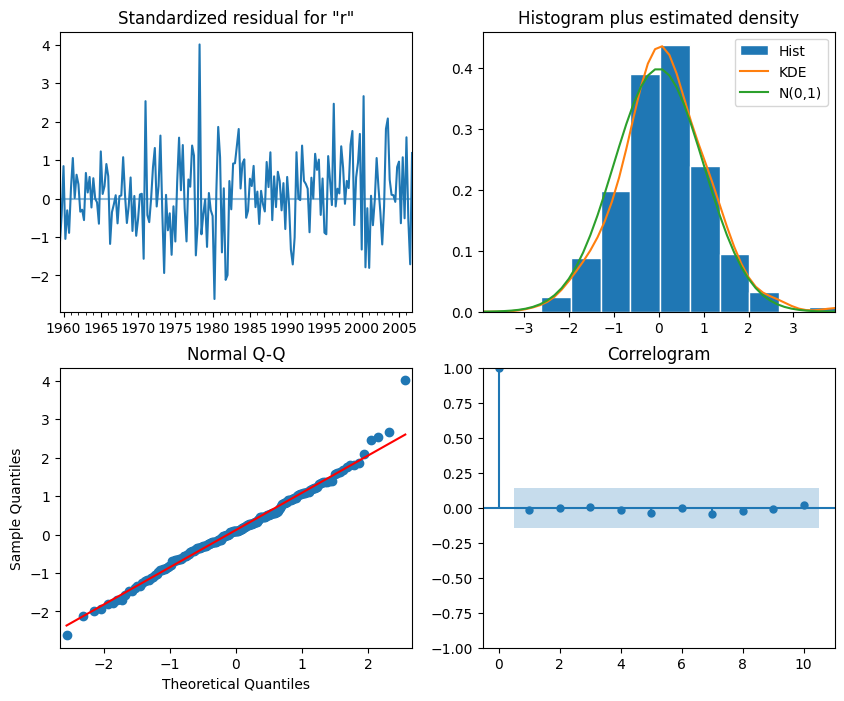

In [127]:

model = ARIMA(train_st, order=(11, 2, 4))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,8));

### Rolling forecast

In [128]:
def rolling_forecast(df, train_len, horizon: int, window: int, order: list):

    total_len = train_len + horizon
    pred_ARIMA = []
    pred_ARIMA_2 = []

    for i in tqdm_notebook(range(train_len, total_len, window)):
        model = ARIMA(df[:i], order=order)
        res = model.fit()
        predictions = res.forecast(window)
        pred_ARIMA.extend(predictions)

    return pred_ARIMA

In [129]:
TRAIN_LEN = len(train_st)
HORIZON = len(test_st)
WINDOW = 1
pred_ARIMA_st = rolling_forecast(st, TRAIN_LEN, HORIZON, WINDOW, (2,1,8))
fechas = test_st.index
st_pred_ARIMA_st = pd.Series(pred_ARIMA_st[:len(fechas)], index=fechas)

mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse



  0%|          | 0/11 [00:00<?, ?it/s]

(11759.11438646859, 108.43945032352659)

### Visualización de las predicciones

(11759.11438646859, 108.43945032352659)

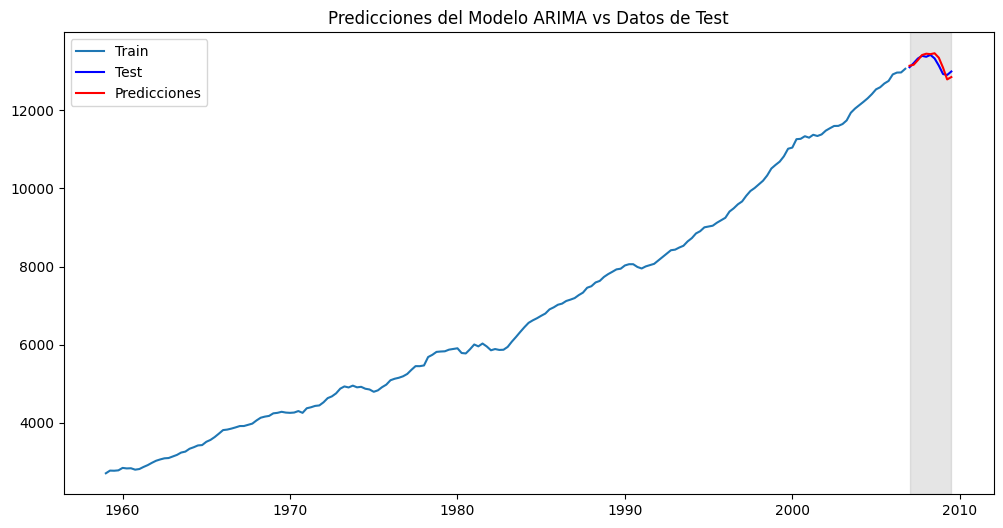

In [130]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(st_pred_ARIMA_st, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse

## Modelo  SARIMA

In [131]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, m: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], m),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df



### Mejor modelo SARIMA

In [132]:
# sarima
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
m = 4

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, m)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 2, 2)",2037.82
1,"(2, 2, 2, 2)",2038.03
2,"(2, 1, 2, 1)",2038.65
3,"(2, 1, 2, 0)",2038.90
4,"(2, 2, 2, 1)",2039.19
...,...,...
76,"(0, 0, 0, 2)",2123.60
77,"(0, 0, 1, 2)",2124.19
78,"(0, 0, 1, 0)",2124.30
79,"(0, 0, 1, 1)",2124.87


### Ajuste Modelo SARIMA

                                       SARIMAX Results                                        
Dep. Variable:                                realgdp   No. Observations:                  192
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 4)   Log Likelihood               -1010.910
Date:                                Thu, 23 Nov 2023   AIC                           2037.821
Time:                                        14:09:06   BIC                           2063.839
Sample:                                    04-01-1959   HQIC                          2048.359
                                         - 01-01-2007                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1837      0.073      2.506      0.012       0.040       0.327
ar.

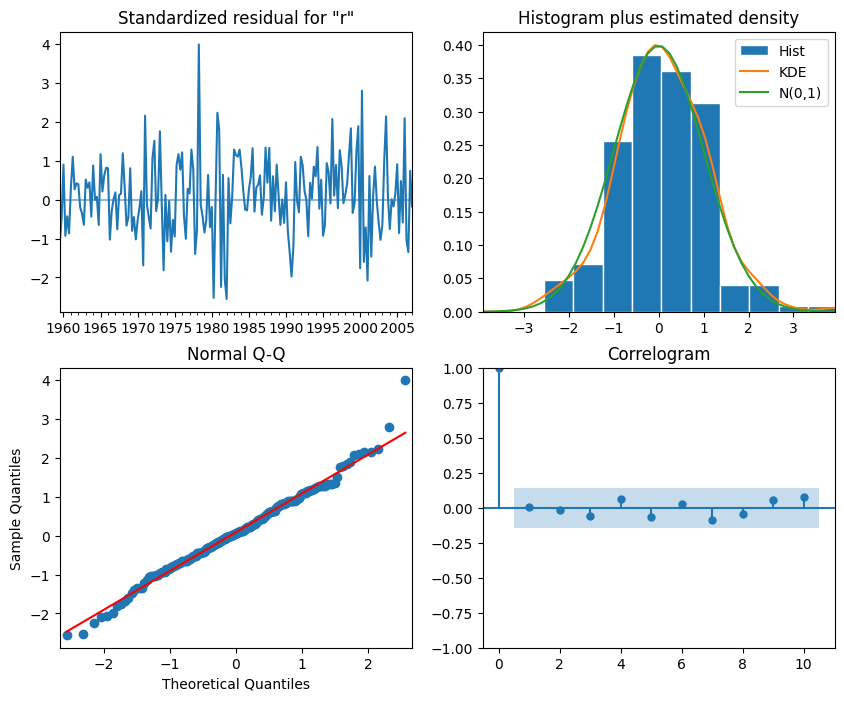

In [133]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(2,0,2,4))
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

### Predicciones

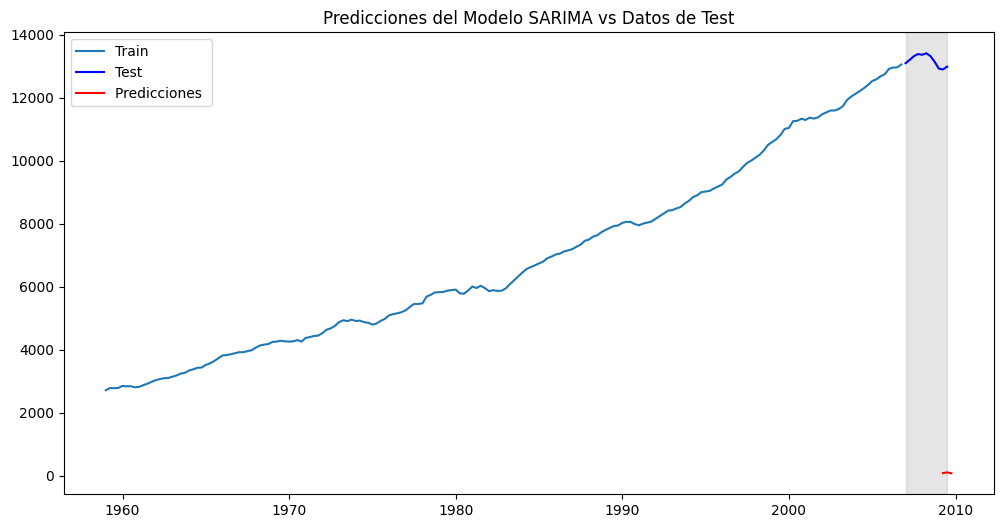

In [134]:
#obtener predicciones y sus intervalos de confianza para un rango específico de índices de tiempo, ya sea dentro del conjunto de datos de entrenamiento (para validación) o para hacer predicciones fuera de la muestra (futuras).

SARIMA_pred = SARIMA_model_fit.get_prediction(start=200, end=202).predicted_mean

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(SARIMA_pred, label='Predicciones ', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo SARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)






## Modelo SARIMAX

In [135]:
def optimize_SARIMAX(endog: Union[pd.Series, list],
                     exog: Union[pd.Series, list],
                     order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC',
                                      ascending=True).reset_index(drop=True)

    return result_df



### Adaptación datos exogenos

In [144]:
target = dataframe['realgdp']
exog = dataframe[['realcons', 'realinv', 'realgovt', 'realdpi','cpi', 'm1','pop']]
dataframe.info()


target_train = target[:192]
exog_train = exog[:192]



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 1959-01-01 to 2009-07-01
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    object 
 1   quarter   203 non-null    object 
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(12), object(2)
memory usage: 23.8+ KB


### Visualización

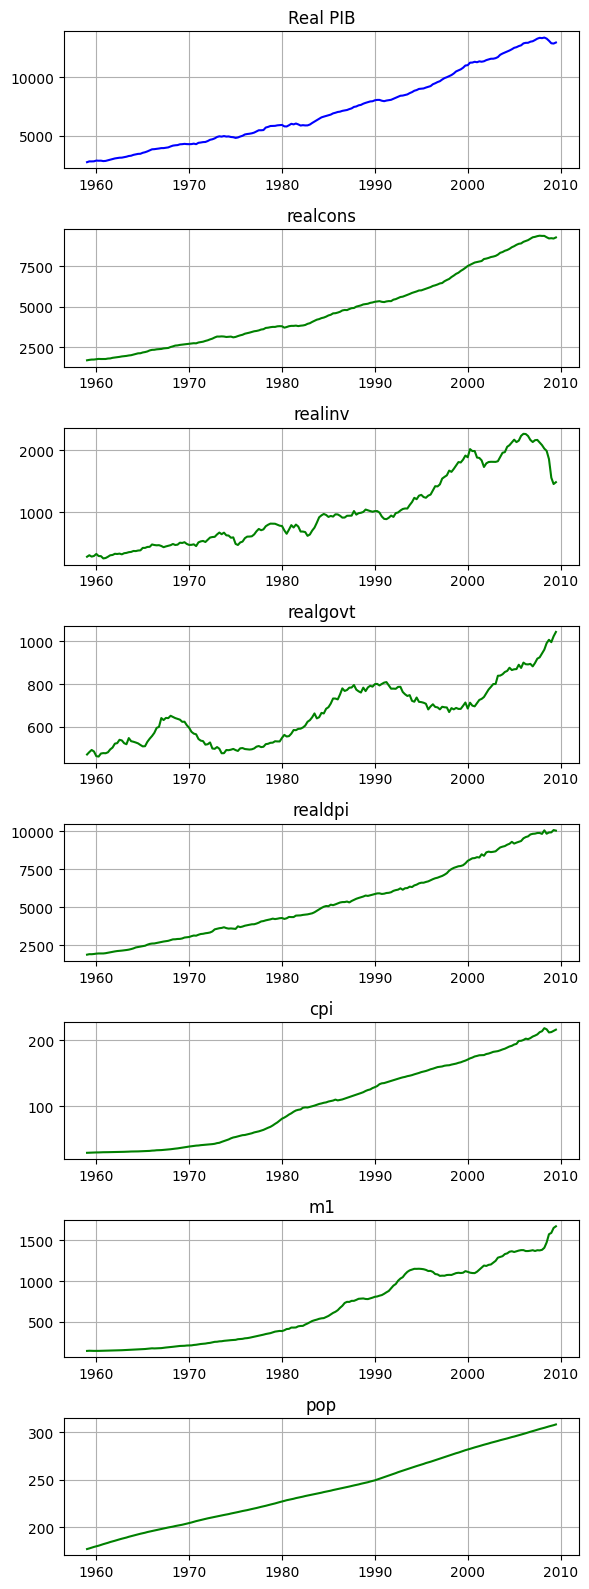

In [137]:
# Crear gráficas
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(6, 16))  # Ajusta el tamaño según sea necesario

# Graficar la variable objetivo
axes[0].plot(target, color='blue')
axes[0].set_title('Real PIB')
axes[0].grid(True)

# Graficar las variables exógenas
for i, col in enumerate(exog.columns):
    axes[i+1].plot(exog[col], color='green')
    axes[i+1].set_title(col)
    axes[i+1].grid(True)

plt.tight_layout()
plt.show()

### mejor modelo SARIMAX

In [138]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1748.14
1,"(3, 3, 1, 0)",1750.25
2,"(3, 3, 0, 1)",1750.53
3,"(2, 2, 0, 0)",1750.57
4,"(2, 2, 0, 1)",1751.14
...,...,...
251,"(1, 0, 3, 1)",1764.50
252,"(0, 3, 0, 0)",1765.17
253,"(0, 0, 0, 0)",1766.13
254,"(1, 0, 0, 0)",1767.63


### Ajuste modelo SARIMAX

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -860.069
Date:                Thu, 23 Nov 2023   AIC                           1748.138
Time:                        14:20:19   BIC                           1794.244
Sample:                    01-01-1959   HQIC                          1766.798
                         - 10-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9508      0.052     18.202      0.000       0.848       1.053
realinv        1.0190      0.035     29.336      0.000       0.951       1.087
realgovt       0.7102      0.137      5.165      0.0

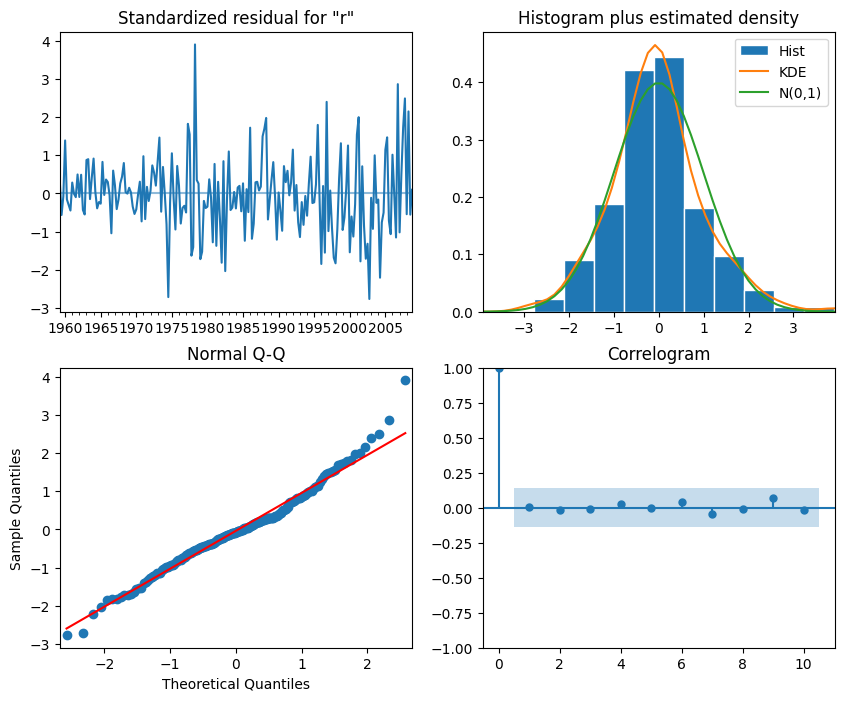

In [139]:
SARIMAX_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)

print(SARIMAX_model_fit.summary())
SARIMAX_model_fit.plot_diagnostics(figsize=(10,8));


### Rolling forecast

In [140]:
def recursive_forecast_SARIMAX(endog: Union[pd.Series, list],
                               exog: Union[pd.Series, list],
                               train_len: int, horizon: int, window: int) -> list:

      pred_SARIMAX = []
      total_len = train_len + horizon

      for i in range(train_len, total_len, window):
          model = SARIMAX(endog[:i], exog[:i], order=(3,1,3),
                          seasonal_order=(0,0,0,4), simple_differencing=False)
          res = model.fit(disp=False)
          predictions = res.get_prediction(exog=exog)
          oos_pred = predictions.predicted_mean.iloc[-window:]
          pred_SARIMAX.extend(oos_pred)

      return pred_SARIMAX

In [145]:
TRAIN_LEN = len(target_train)
HORIZON = len(test_st)
WINDOW = 1
pred_SARIMAX = recursive_forecast_SARIMAX(target, exog, TRAIN_LEN, HORIZON, WINDOW)

fechas = test_st.index
st_pred_SARIMAX = pd.Series(pred_SARIMAX[:len(fechas)], index=fechas)

mse_SARIMAX = mean_squared_error(test_st, st_pred_SARIMAX)
rmse_SARIMAX = np.sqrt(mse_SARIMAX)

mse_SARIMAX, rmse_SARIMAX

(13438.787821380103, 115.92578583464554)

### Visualización

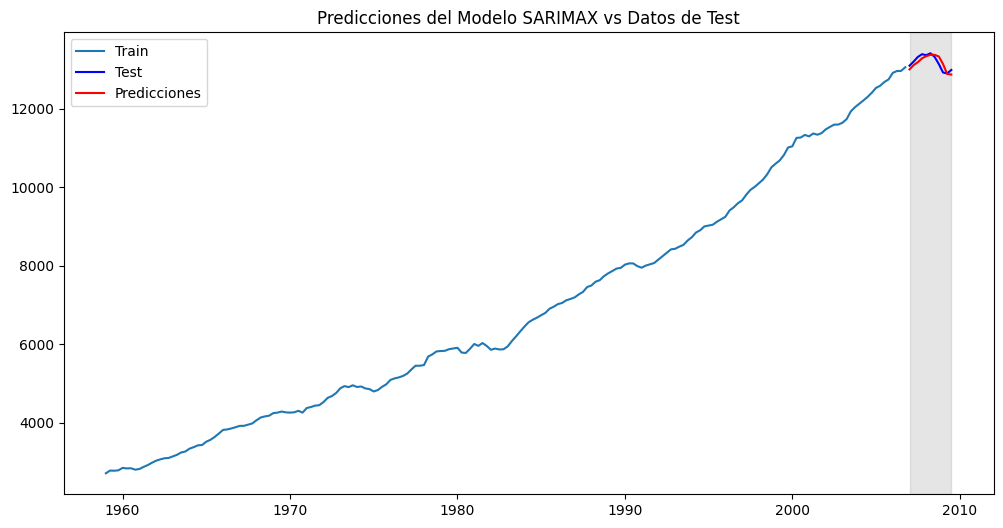

In [147]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(st_pred_SARIMAX, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo SARIMAX vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)

## modelo VAR

In [12]:
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:

    results = []

    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue

        aic = model.aic
        results.append([i, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

### Mejor Modelo VAR

In [13]:
endog = dataframe[['realdpi', 'realcons']]

endog_diff = dataframe[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.07
1,5,3123.71
2,6,3126.86
3,4,3129.19
4,2,3130.09
5,7,3133.40
6,1,3134.33
7,8,3137.15
8,9,3140.37
9,10,3147.84


###  Granger-causes

In [17]:
print('\nrealdpi Granger-causes realcons?\n')
granger_1 = grangercausalitytests(dataframe[['realdpi', 'realcons']].diff()[1:], [3])

print('realcons Granger-causes realdpi?\n')
granger_2 = grangercausalitytests(dataframe[['realcons', 'realdpi']].diff()[1:], [3])




realdpi Granger-causes realcons?


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
realcons Granger-causes realdpi?


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


### Ajuste Modelo

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Thu, 23 Nov 2023   BIC                           3175.559
Time:                             17:52:31   HQIC                          3144.381
Sample:                         04-01-1959                                         
                              - 07-01-1999                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

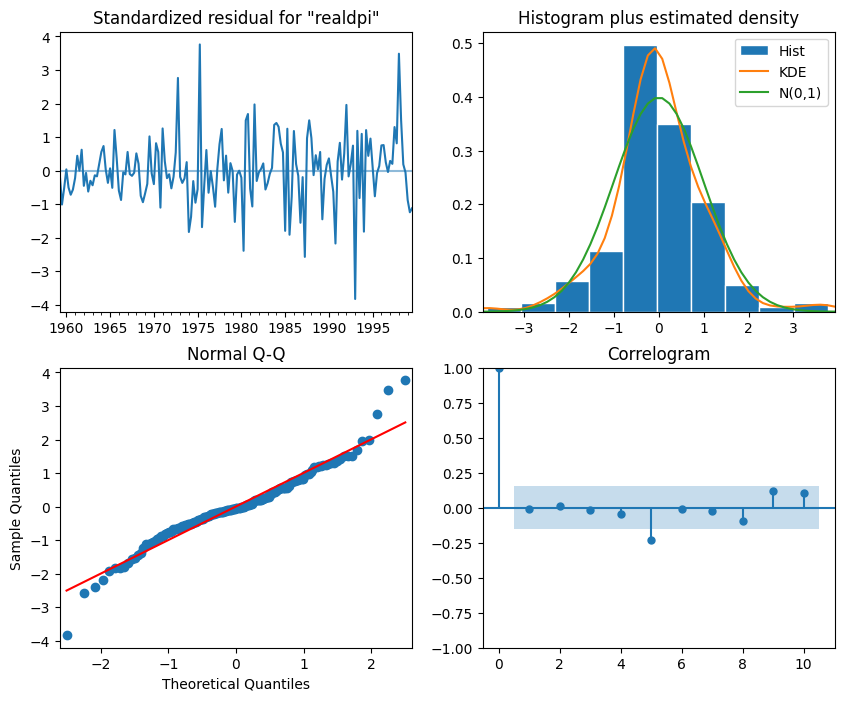

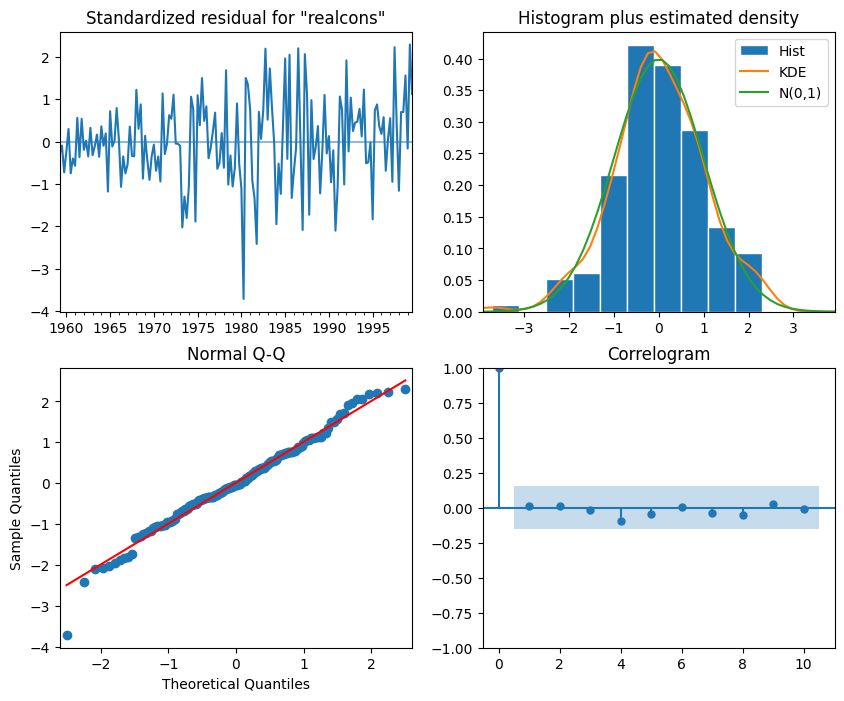

In [21]:
VAR_model = VARMAX(train, order=(3,0))
VAR_model_fit = VAR_model.fit(disp=False)

print(VAR_model_fit.summary())
VAR_model_fit.plot_diagnostics(figsize=(10,8), variable=0);
VAR_model_fit.plot_diagnostics(figsize=(10,8), variable=1);


### Predicciones

In [25]:
def rolling_forecast_VAR(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    realdpi_pred_VAR = []
    realcons_pred_VAR = []

    for i in range(train_len, total_len, window):
        model = VARMAX(df[:i], order=(3,0))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)

        oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
        oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

        realdpi_pred_VAR.extend(oos_pred_realdpi)
        realcons_pred_VAR.extend(oos_pred_realcons)

    return realdpi_pred_VAR, realcons_pred_VAR



In [27]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast_VAR(endog_diff, TRAIN_LEN, HORIZON, WINDOW)

print(realdpi_pred_VAR)
print(realcons_pred_VAR)